In [3]:
!pip freeze

asttokens==3.0.0
colorama==0.4.6
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.15
decorator==5.2.1
executing==2.2.0
filelock==3.13.1
fonttools==4.59.0
fsspec==2024.6.1
ipykernel==6.30.1
ipython==9.4.0
ipython_pygments_lexers==1.1.1
jedi==0.19.2
Jinja2==3.1.4
joblib==1.5.1
jupyter_client==8.6.3
jupyter_core==5.8.1
kiwisolver==1.4.8
MarkupSafe==2.1.5
matplotlib==3.10.5
matplotlib-inline==0.1.7
mpmath==1.3.0
nest-asyncio==1.6.0
networkx==3.3
numpy==2.3.2
packaging==25.0
pandas==2.3.1
parso==0.8.4
pillow==11.3.0
platformdirs==4.3.8
prompt_toolkit==3.0.51
psutil==7.0.0
pure_eval==0.2.3
Pygments==2.19.2
pyparsing==3.2.3
python-dateutil==2.9.0.post0
pytz==2025.2
pywin32==311
pyzmq==27.0.1
scikit-learn==1.7.1
scipy==1.16.1
seaborn==0.13.2
six==1.17.0
stack-data==0.6.3
sympy==1.13.3
threadpoolctl==3.6.0
torch==2.8.0+cpu
torchaudio==2.8.0+cpu
torchvision==0.23.0+cpu
tornado==6.5.1
traitlets==5.14.3
typing_extensions==4.14.1
tzdata==2025.2
wcwidth==0.2.13


100.0%
100.0%
100.0%
100.0%


Case 1: 가중치와 편향을 모두 0으로 초기화
--- 'zeros' 방식으로 가중치 초기화 ---
Epoch 1/5, Test Accuracy: 11.35%
Epoch 2/5, Test Accuracy: 11.35%
Epoch 3/5, Test Accuracy: 11.35%
Epoch 4/5, Test Accuracy: 11.35%
Epoch 5/5, Test Accuracy: 11.35%

Case 2: 가중치는 1, 편향은 0으로 초기화
--- 'ones' 방식으로 가중치 초기화 ---
Epoch 1/5, Test Accuracy: 11.35%
Epoch 2/5, Test Accuracy: 11.35%
Epoch 3/5, Test Accuracy: 11.35%
Epoch 4/5, Test Accuracy: 11.35%
Epoch 5/5, Test Accuracy: 11.35%

Case 3: 헤(He) 방식으로 올바르게 초기화
--- 'he' 방식으로 가중치 초기화 ---
Epoch 1/5, Test Accuracy: 90.70%
Epoch 2/5, Test Accuracy: 92.35%
Epoch 3/5, Test Accuracy: 92.71%
Epoch 4/5, Test Accuracy: 93.33%
Epoch 5/5, Test Accuracy: 94.02%


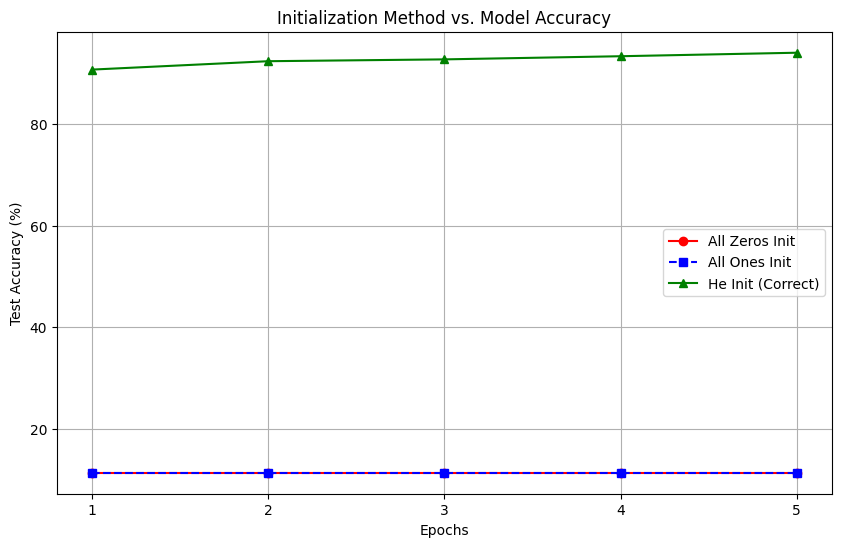

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- 하이퍼파라미터 설정 ---
epochs = 5
batch_size = 64
learning_rate = 0.01

# --- 데이터 로드 (MNIST) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform),
    batch_size=batch_size, shuffle=False)

# --- 신경망 모델 정의 ---
class SimpleNet(nn.Module):
    def __init__(self, init_type='he'):
        super(SimpleNet, self).__init__()
        # 784(input) -> 128 -> 64 -> 10(output)
        self.fc1 = nn.Linear(784, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 10)
        
        # 여기서 가중치 초기화를 결정합니다.
        self._initialize_weights(init_type)

    def _initialize_weights(self, init_type):
        print(f"--- '{init_type}' 방식으로 가중치 초기화 ---")
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if init_type == 'zeros':
                    nn.init.constant_(m.weight, 0)
                    nn.init.constant_(m.bias, 0)
                elif init_type == 'ones':
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif init_type == 'he': # 올바른 방식
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(-1, 784) # Flatten a 28x28 image to a 784 vector
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 학습 및 평가 함수 ---
def train_and_evaluate(init_type):
    model = SimpleNet(init_type=init_type)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    accuracies = []
    for epoch in range(epochs):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        # 매 에포크마다 정확도 평가
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        print(f'Epoch {epoch+1}/{epochs}, Test Accuracy: {accuracy:.2f}%')
    
    return accuracies

# --- 각 케이스별로 실험 실행 ---
print("="*40)
print("Case 1: 가중치와 편향을 모두 0으로 초기화")
print("="*40)
acc_zeros = train_and_evaluate('zeros')

print("\n" + "="*40)
print("Case 2: 가중치는 1, 편향은 0으로 초기화")
print("="*40)
acc_ones = train_and_evaluate('ones')

print("\n" + "="*40)
print("Case 3: 헤(He) 방식으로 올바르게 초기화")
print("="*40)
acc_he = train_and_evaluate('he')

# --- 결과 시각화 ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), acc_zeros, 'r-o', label='All Zeros Init')
plt.plot(range(1, epochs + 1), acc_ones, 'b--s', label='All Ones Init')
plt.plot(range(1, epochs + 1), acc_he, 'g-^', label='He Init (Correct)')
plt.title('Initialization Method vs. Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

# 🔬 순수 NumPy로 보는 가중치 초기화 vs 학습 동역학 (Synthetic Data)

이 실험은 **외부 데이터 다운로드 없이** 임의로 생성한 합성(synthetic) 다중분류 데이터에 대해
가중치 초기화 방식이 학습 과정(활성/그래디언트/정확도)에 어떤 차이를 만드는지 관찰합니다.

구성
- 입력 차원: 784 (MNIST와 동일한 차원만 차용)
- 클래스 수: 10
- 데이터 생성: X ~ N(0,1), 숨은 진짜 분류용 가중치 W_true 로부터 logits = X W_true + noise 생성 후 argmax 로 라벨 결정
- Train 10,000 / Test 2,000 샘플 (필요시 줄여서 빠르게 시험 가능)

비교 초기화 방법
1. zeros : 모든 가중치 0 (대칭성 → 학습 불능 예상)
2. ones  : 모든 가중치 1 (대칭성 + 비효율)
3. he    : He Normal (ReLU 층에 적합, 가장 안정 기대)

관찰 지표
- Epoch별 Test Accuracy 곡선
- 첫 미니배치 층별 활성값 (mean, std)
- Epoch별(누적 평균) 층별 가중치 gradient L2 norm

의도
- 올바르지 않은 초기화가 학습 신호(gradient)와 표현력에 어떤 제약을 주는지 직관적 비교

추가 확장 아이디어 (원하면 나중에 적용 가능)
- Xavier 초기화 추가
- Gradient 분포 히스토그램
- LayerNorm / BatchNorm 삽입 효과 비교
- 깊이(레이어 수) 증가 시 폭발/소실 경향 관찰


In [6]:
import numpy as np
import math

# ---- 합성 데이터 생성 ----
# 입력 784, 클래스 10, 선형 결정경계 기반 라벨 + 약간의 노이즈

INPUT_DIM = 784
NUM_CLASSES = 10
N_TRAIN = 10_000
N_TEST = 2_000

rng = np.random.default_rng(42)

# 숨은 진짜 가중치 (784 x 10)
W_true = rng.normal(0, 1.0/np.sqrt(INPUT_DIM), size=(INPUT_DIM, NUM_CLASSES)).astype(np.float32)
b_true = rng.normal(0, 0.01, size=(1, NUM_CLASSES)).astype(np.float32)

def make_dataset(n):
    X = rng.normal(0, 1, size=(n, INPUT_DIM)).astype(np.float32)
    logits = X @ W_true + b_true + rng.normal(0, 0.1, size=(n, NUM_CLASSES)).astype(np.float32)
    y = logits.argmax(axis=1).astype(np.int64)
    return X, y

X_train, y_train = make_dataset(N_TRAIN)
X_test, y_test = make_dataset(N_TEST)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# ---- Mini-batch iterator ----

def batch_iter(X, y, batch_size, shuffle=True):
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    for i in range(0, n, batch_size):
        j = idx[i:i+batch_size]
        yield X[j], y[j]


Train shape: (10000, 784) Test shape: (2000, 784)


## 📥 scikit-learn MNIST로 전환 (선택)
아래 셀을 실행하면 합성 데이터 대신 **scikit-learn `fetch_openml` MNIST (28x28=784)**를 로드하여 동일한 NumPy MLP 초기화 실험을 수행할 수 있습니다.

옵션
- use_subset: True이면 빠른 실험을 위해 10k/2k로 축소
- normalize_zero_mean: 평균 0, 표준편차 1 정규화 (He 초기화와 잘 맞음)

실행 후 `X_train.shape` 출력이 바뀌면 이후 학습 셀(초기화 실험 실행)을 다시 돌리면 됩니다.


In [14]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# ---- scikit-learn MNIST 로드 ----
use_subset = True          # 빠른 테스트용
subset_train = 10000
subset_test = 2000
normalize_zero_mean = True
random_state = 42

print('Fetching MNIST (openml)... 처음 1회만 다소 소요될 수 있음')
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='pandas')
X = mnist.data.astype('float32') / 255.0  # [0,1]
y = mnist.target.astype('int64')

# 선택: 0-1 스케일 → 평균0/표준편차1 정규화 (He 안정성 개선)
if normalize_zero_mean:
    mean = X.mean(axis=0, keepdims=True)
    std = X.std(axis=0, keepdims=True) + 1e-6
    X = (X - mean) / std

# Train/Test 분할 (기존 synthetic 대체)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=10000, random_state=random_state, stratify=y)

if use_subset:
    X_train = X_train_full[:subset_train]
    y_train = y_train_full[:subset_train]
    X_test = X_test_full[:subset_test]
    y_test = y_test_full[:subset_test]
else:
    X_train, y_train = X_train_full, y_train_full
    X_test, y_test = X_test_full, y_test_full

print('MNIST shapes ->', X_train.shape, X_test.shape)
print('Label distribution (train) sample:', np.unique(y_train, return_counts=True)[1][:10])


Fetching MNIST (openml)... 처음 1회만 다소 소요될 수 있음


c:\Users\brigh\Documents\GitHub\AI-Lab\venv\Lib\site-packages\sklearn\datasets\_openml.py:109: UserWarning: A network error occurred while downloading https://api.openml.org/data/v1/download/52667/mnist_784.arff. Retrying...
  warn(


HTTPError: HTTP Error 404: Not Found

In [ ]:
# ---- MLP (784-128-64-10) 순수 NumPy ----
# 합성 데이터(정규분포) 기반 다중분류 학습 실험
class NumpyMLP:
    def __init__(self, init_type='he'):
        self.init_type = init_type
        # self.shapes = [(784,128), (128,64), (64,10)]
        self.shapes = [(784,128), (128,64), (64,10)]
        self.params = {}
        self._init_params()

    def _init_params(self):
        for i,(fan_in, fan_out) in enumerate(self.shapes):
            keyW = f'W{i+1}'; keyb = f'b{i+1}'
            if self.init_type == 'zeros':
                W = np.zeros((fan_in, fan_out), dtype=np.float32)
            elif self.init_type == 'ones':
                W = np.ones((fan_in, fan_out), dtype=np.float32)
            elif self.init_type == 'he':
                # He normal: N(0, 2/fan_in)
                W = np.random.randn(fan_in, fan_out).astype(np.float32) * math.sqrt(2.0/fan_in)
            else:
                raise ValueError('unknown init')
            b = np.zeros((1, fan_out), dtype=np.float32)
            self.params[keyW] = W
            self.params[keyb] = b

    def forward(self, X):
        cache = {'A0': X}
        A = X
        for i in range(1,4):
            W = self.params[f'W{i}']; b = self.params[f'b{i}']
            Z = A @ W + b
            cache[f'Z{i}'] = Z
            if i<3:
                A = np.maximum(0,Z)
            else:
                A = Z  # logits
            cache[f'A{i}'] = A
        return A, cache

    def softmax(self, logits):
        z = logits - logits.max(axis=1, keepdims=True)
        exp = np.exp(z)
        return exp / exp.sum(axis=1, keepdims=True)

    def compute_loss_and_grad(self, logits, y):
        B = y.shape[0]
        probs = self.softmax(logits)
        loss = -np.log(probs[np.arange(B), y] + 1e-9).mean()
        grad = probs
        grad[np.arange(B), y] -= 1
        grad /= B
        return loss, grad

    def backward(self, cache, grad_logits):
        grads = {}
        dA = grad_logits
        for i in reversed(range(1,4)):
            A_prev = cache[f'A{i-1}']
            Z = cache[f'Z{i}']
            W = self.params[f'W{i}']
            if i<3:
                dZ = dA * (Z>0)
            else:
                dZ = dA
            dW = A_prev.T @ dZ
            db = dZ.sum(axis=0, keepdims=True)
            if i>1:
                dA = dZ @ W.T
            grads[f'dW{i}'] = dW
            grads[f'db{i}'] = db
        return grads

    def step(self, grads, lr):
        for i in range(1,4):
            self.params[f'W{i}'] -= lr * grads[f'dW{i}']
            self.params[f'b{i}'] -= lr * grads[f'db{i}']

# ---- 평가 ----

def evaluate(model: NumpyMLP, X, y, batch_size=256):
    correct=0; total=0
    for i in range(0, X.shape[0], batch_size):
        xb = X[i:i+batch_size]
        yb = y[i:i+batch_size]
        logits,_ = model.forward(xb)
        pred = logits.argmax(axis=1)
        correct += (pred==yb).sum()
        total += yb.size
    return 100.0*correct/total

# ---- 학습 함수 ----

def train_numpy(init_type, epochs=5, batch_size=128, lr=0.1):
    model = NumpyMLP(init_type=init_type)
    history = {'loss':[], 'acc':[], 'grad_norms':[], 'act_stats':None}
    grad_norm_accum = np.zeros(3, dtype=np.float64)
    batches = 0
    first_batch_act_stats = None
    for ep in range(1, epochs+1):
        for xb,yb in batch_iter(X_train, y_train, batch_size, shuffle=True):
            batches += 1
            logits, cache = model.forward(xb)
            if first_batch_act_stats is None:
                act = []
                for i in range(1,4):
                    A = cache[f'A{i}']
                    act.append((float(A.mean()), float(A.std())))
                first_batch_act_stats = act
            loss, grad_logits = model.compute_loss_and_grad(logits, yb)
            grads = model.backward(cache, grad_logits)
            for li in range(1,4):
                g = grads[f'dW{li}']
                grad_norm_accum[li-1] += np.linalg.norm(g)/g.size
            model.step(grads, lr)
        acc = evaluate(model, X_test, y_test)
        history['loss'].append(loss)
        history['acc'].append(acc)
        history['grad_norms'].append(grad_norm_accum / batches)
        print(f"[{init_type}] Epoch {ep}/{epochs} loss={loss:.4f} acc={acc:.2f}% grad_norms={history['grad_norms'][-1]}")
    history['act_stats'] = first_batch_act_stats
    return history


In [9]:
# ---- 세 가지 초기화 실험 실행 (Synthetic Data) ----
exp_histories = {}
for init in ['zeros','ones','he']:
    exp_histories[init] = train_numpy(init, epochs=5, batch_size=256, lr=0.1)



[zeros] Epoch 1/5 loss=2.3033 acc=10.60% grad_norms=[0. 0. 0.]
[zeros] Epoch 2/5 loss=2.3078 acc=10.60% grad_norms=[0. 0. 0.]
[zeros] Epoch 3/5 loss=2.3011 acc=10.55% grad_norms=[0. 0. 0.]
[zeros] Epoch 4/5 loss=2.2970 acc=10.55% grad_norms=[0. 0. 0.]
[zeros] Epoch 5/5 loss=2.3078 acc=10.55% grad_norms=[0. 0. 0.]
[ones] Epoch 1/5 loss=2.3005 acc=10.60% grad_norms=[0.001292   0.01781757 0.56288976]
[ones] Epoch 2/5 loss=2.3024 acc=10.15% grad_norms=[0.000646   0.00890878 0.28144488]
[ones] Epoch 3/5 loss=2.3003 acc=10.60% grad_norms=[0.00043067 0.00593919 0.18762992]
[zeros] Epoch 5/5 loss=2.3078 acc=10.55% grad_norms=[0. 0. 0.]
[ones] Epoch 1/5 loss=2.3005 acc=10.60% grad_norms=[0.001292   0.01781757 0.56288976]
[ones] Epoch 2/5 loss=2.3024 acc=10.15% grad_norms=[0.000646   0.00890878 0.28144488]
[ones] Epoch 3/5 loss=2.3003 acc=10.60% grad_norms=[0.00043067 0.00593919 0.18762992]
[ones] Epoch 4/5 loss=2.2994 acc=10.60% grad_norms=[0.000323   0.00445439 0.14072244]
[ones] Epoch 5/5 los

In [10]:
# ---- 결과 요약 출력 ----
for k,h in exp_histories.items():
    print(f"\n== {k} 최종 정확도: {h['acc'][-1]:.2f}%")
    print("첫 배치 활성 (mean,std) 층1/층2/로그릿:", h['act_stats'])


== zeros 최종 정확도: 10.55%
첫 배치 활성 (mean,std) 층1/층2/로그릿: [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]

== ones 최종 정확도: 10.60%
첫 배치 활성 (mean,std) 층1/층2/로그릿: [(12.505762100219727, 17.163965225219727), (1600.737548828125, 2196.987548828125), (102447.203125, 140607.203125)]

== he 최종 정확도: 34.05%
첫 배치 활성 (mean,std) 층1/층2/로그릿: [(0.5604233741760254, 0.8273441195487976), (0.5644965171813965, 0.8135008215904236), (-0.42763543128967285, 1.393858551979065)]


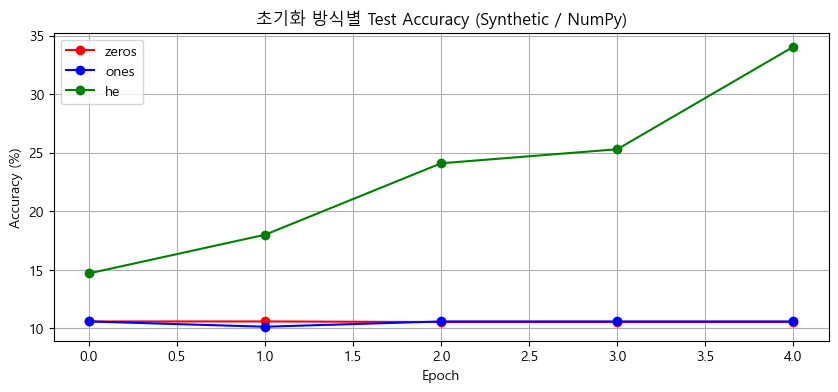

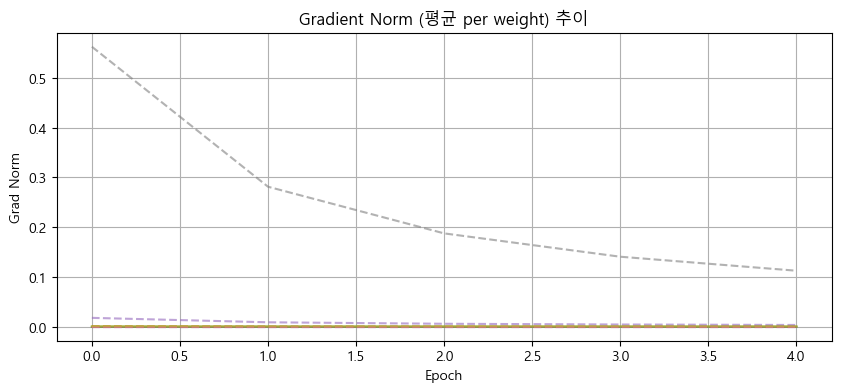

In [13]:
# ---- 시각화 ----
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(10,4))
for init,c in [('zeros','r'),('ones','b'),('he','g')]:
    plt.plot(exp_histories[init]['acc'], c+'-o', label=init)
plt.title('초기화 방식별 Test Accuracy (Synthetic / NumPy)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
for li in range(3):
    for init,c in [('zeros','r'),('ones','b'),('he','g')]:
        gn = [v[li] for v in exp_histories[init]['grad_norms']]
        plt.plot(gn, label=f'{init}-L{li+1}' if li==0 else None, alpha=0.6, linestyle='--' if init!='he' else '-')
plt.title('Gradient Norm (평균 per weight) 추이')
plt.xlabel('Epoch'); plt.ylabel('Grad Norm')
plt.grid(True)
plt.show()